# INIT

In [2]:
from dataclasses import dataclass
from datasets import load_dataset

from torchvision import transforms
import torch

from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F
from matplotlib import pyplot as plt
from accelerate import notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from PIL import Image
import glob
import numpy as np
from torchvision.transforms import InterpolationMode



In [3]:

@dataclass
class TrainingConfig:
    image_size = 128  
    train_batch_size = 16
    eval_batch_size = 16 
    num_epochs = 500
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 1000
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = "fp16" 
    output_dir = "ddpm-butterflies-upscaling-128" 

    push_to_hub = False 
    overwrite_output_dir = True  
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



config = TrainingConfig()



# DATASET

In [4]:
config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

total_size = len(dataset)
train_size = int(0.8 * total_size)
dataset_train = dataset.select(range(train_size))
dataset_eval = dataset.select(range(train_size, total_size))

Repo card metadata block was not found. Setting CardData to empty.


In [5]:

def pad_to_square(image):
    width, height = image.size
    
    max_dim = max(width, height)
    
    pad_left = (max_dim - width) // 2
    pad_right = max_dim - width - pad_left
    pad_top = (max_dim - height) // 2
    pad_bottom = max_dim - height - pad_top
    
    padding = (pad_left, pad_top, pad_right, pad_bottom)
    return transforms.Pad(padding, fill = 255, padding_mode = 'constant')(image)

preprocess = transforms.Compose([
    transforms.Lambda(pad_to_square),  
    transforms.Resize((config.image_size, config.image_size)),
])

high_res_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

low_res_preprocess_new_dim = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: F.avg_pool2d(x, kernel_size=2)),
    transforms.Normalize([0.5], [0.5]),
])

low_res_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: F.avg_pool2d(x, kernel_size=2)),
    transforms.Resize(
        (config.image_size, config.image_size),  
        interpolation=InterpolationMode.NEAREST_EXACT 
    ),
    transforms.Normalize([0.5], [0.5]),
])

def transform(examples):
    high_res_images = []
    low_res_images = []
    low_res_images_new_dim = []
    for image in examples['image']:
        pre_img = preprocess(image.convert("RGB"))
        high_res_images.append(high_res_preprocess(pre_img))
        low_res_images.append(low_res_preprocess(pre_img))
        low_res_images_new_dim.append(low_res_preprocess_new_dim(pre_img))
    
    return {
        "high_res_images": high_res_images,
        "low_res_images": low_res_images,
        'low_res_images_new_dim': low_res_images_new_dim
    }

dataset_train.set_transform(transform)
dataset_eval.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=config.train_batch_size, shuffle=False)
eval_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=config.train_batch_size, shuffle=False)

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


C:\Users\simon\AppData\Local\Temp\ipykernel_14528\887027130.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\simon\AppData\Local\Temp\ipykernel_14528\887027130.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\simon\AppData\Local\Temp\ipykernel_14528\887027130.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


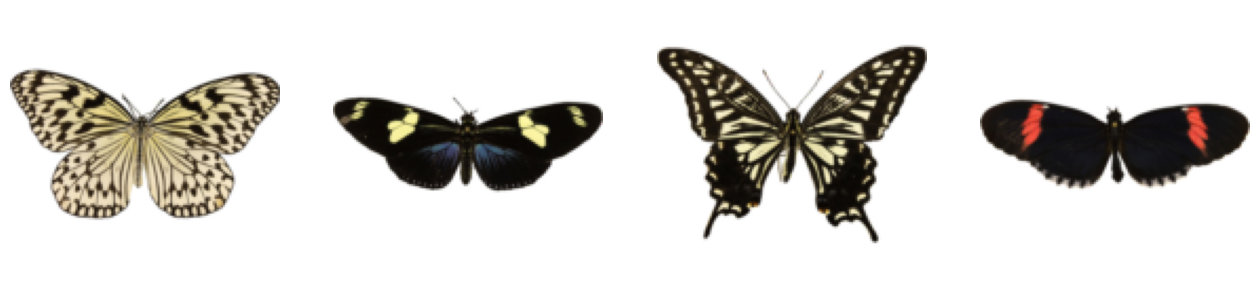

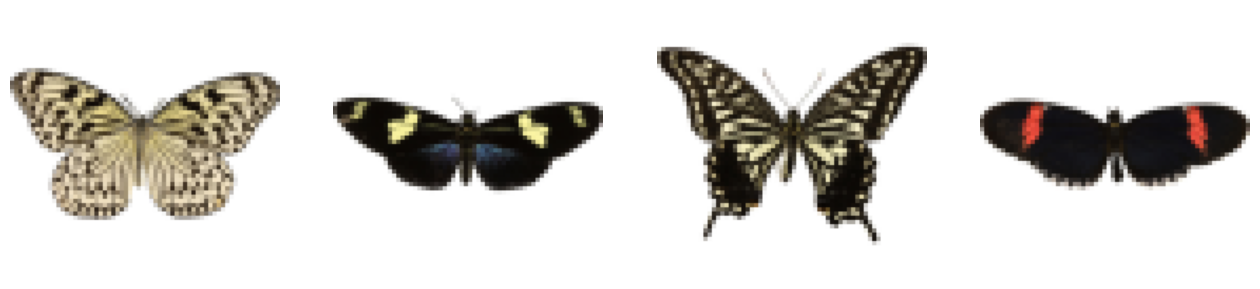

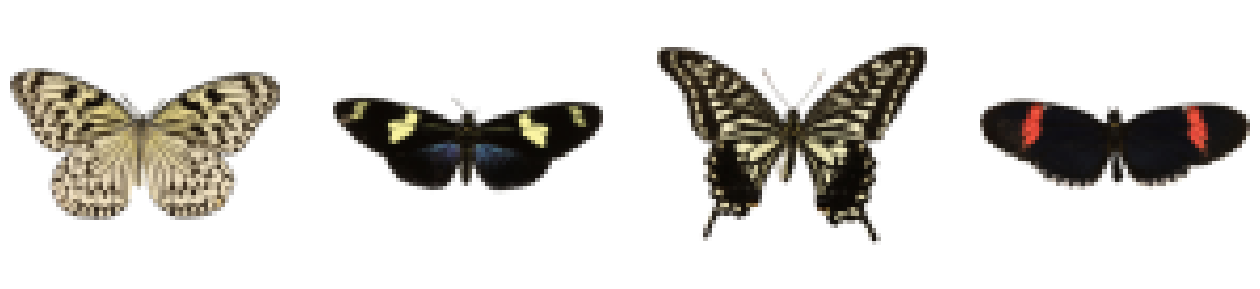

In [6]:
def undo_normalize(tensor):
    # Reverses Normalize([0.5], [0.5]) to get back to [0, 1]
    return (tensor + 1) / 2

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset_train[:4]["high_res_images"]):
    print(image.shape)
    axs[i].imshow(undo_normalize(image.permute(1, 2, 0)))
    axs[i].set_axis_off()
    fig.show()


fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset_train[:4]["low_res_images"]):
    print(image.shape)
    axs[i].imshow(undo_normalize(image.permute(1, 2, 0)))
    axs[i].set_axis_off()
    fig.show()


fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset_train[:4]["low_res_images_new_dim"]):
    print(image.shape)
    axs[i].imshow(undo_normalize(image.permute(1, 2, 0)))
    axs[i].set_axis_off()
    fig.show()

In [13]:
from diffusers import UNet2DModel
from diffusers import UNet2DConditionModel

model = UNet2DModel(
    sample_size=config.image_size,  
    in_channels=3,  
    out_channels=3,  
    layers_per_block=2,  
    block_out_channels=(128, 128, 256, 256, 512, 512),  
    down_block_types=(
        "DownBlock2D",  
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  
        "AttnUpBlock2D",  
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)



# TRAINING

In [14]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process, desc=f"Epoch {epoch}")
        epoch_loss = 0.0  
        num_batches = 0   
        
        for step, batch in enumerate(train_dataloader):
            high_res_images = batch["high_res_images"]  

            noise = torch.randn(high_res_images.shape, device=high_res_images.device)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (high_res_images.shape[0],), device=high_res_images.device, dtype=torch.int64)
            noisy_images = noise_scheduler.add_noise(high_res_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                
                loss = F.mse_loss(noise_pred, noise)
                
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

            epoch_loss += loss.item()
            num_batches += 1


        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed),
    ).images
    image_grid = make_image_grid(images, rows=4, cols=4)
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

def evaluate(config, epoch, pipeline, num_inference_steps=1000):
    low_res_img = torch.cat([d.unsqueeze(0) for d in dataset_train[:16]["low_res_images"]], dim = 0).to(config.device)
    images = torch.randn(low_res_img.shape, device=config.device)
    
    pipeline.scheduler.set_timesteps(num_inference_steps)
    progress_bar = tqdm(total=num_inference_steps, desc=f"yoyoyo")

    pipeline.unet.eval()
    pipeline.unet.to(config.device)

    for t in pipeline.scheduler.timesteps:
        timestep = torch.full((1,), t, device=config.device, dtype=torch.long)
        with torch.no_grad():
            model_input = torch.concat([images, low_res_img], axis = 1).to(config.device)
            noise_pred = pipeline.unet(images, timestep).sample
        
        images = pipeline.scheduler.step(noise_pred, t, images).prev_sample
        progress_bar.update(1)
    
    images_pp = (images / 2 + 0.5).clamp(0, 1)
    images_pp = images_pp.cpu().permute(0, 2, 3, 1).numpy()
    images_pp = (images_pp * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images_pp]
    image_grid = make_image_grid(pil_images, rows=4, cols=4)
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

    pipeline.unet.train()
    return images.detach().cpu()


In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)




# EVALUATING

In [105]:
import importlib
import sys 
sys.path.append(os.path.abspath('..'))
import custom_scheduler_upscaling
importlib.reload(custom_scheduler_upscaling)
import custom_scheduler_base
importlib.reload(custom_scheduler_base)

def evaluate_arbitrary(config, epoch, pipeline, num_inference_steps=1000):
    
    low_res_img = torch.cat([d.unsqueeze(0) for d in dataset_train[:16]["low_res_images"]], dim = 0).to(config.device)
    images = torch.randn(low_res_img.shape, device=config.device)
    
    pipeline.scheduler.set_timesteps(num_inference_steps)
    progress_bar = tqdm(total=num_inference_steps, desc=f"yoyoyo")

    pipeline.unet.eval()
    pipeline.unet.to(config.device)

    for t in pipeline.scheduler.timesteps:
        timestep = torch.full((1,), t, device=config.device, dtype=torch.long)
        with torch.no_grad():
            noise_pred = pipeline.unet(images, timestep).sample
        
        images = pipeline.scheduler.step(noise_pred, t, images).prev_sample
        progress_bar.update(1)
    
    # Save images
    images_pp = (images / 2 + 0.5).clamp(0, 1)
    images_pp = images_pp.cpu().permute(0, 2, 3, 1).numpy()
    images_pp = (images_pp * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images_pp]
    image_grid = make_image_grid(pil_images, rows=4, cols=4)
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

    pipeline.unet.train()
    return images.detach().cpu()




def evaluate_upsampling(config, epoch, pipeline, low_res_images, num_inference_steps=1000, initial_t=100, save_img = True):
    initial_images = low_res_images.to(config.device)
    
    pipeline.scheduler.set_timesteps(num_inference_steps)
    ts = pipeline.scheduler.timesteps
    
    initial_t = ts[torch.argmin(torch.abs(initial_t - ts))]
    
    noise = torch.randn_like(initial_images)
    timesteps = torch.LongTensor([initial_t]).to(config.device)

    images = pipeline.scheduler.add_noise(initial_images, noise, timesteps)

    ts = ts[ts < initial_t]
    
    pipeline.unet.eval()
    pipeline.unet.to(config.device)
    
    progress_bar = tqdm(total=len(ts), desc=f"Upsampling")
    
    for t in ts:
        timestep = torch.full((1,), t, device=config.device, dtype=torch.long)
        with torch.no_grad():
            noise_pred = pipeline.unet(images, timestep).sample
        
        images = pipeline.scheduler.step(noise_pred, t, images).prev_sample
        progress_bar.update(1)

    if save_img:
        images_pp = (images / 2 + 0.5).clamp(0, 1)
        images_pp = images_pp.cpu().permute(0, 2, 3, 1).numpy()
        images_pp = (images_pp * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images_pp]
        image_grid = make_image_grid(pil_images, rows=4, cols=4)
        
        # Save results
        test_dir = os.path.join(config.output_dir, "samples")
        os.makedirs(test_dir, exist_ok=True)
        image_grid.save(f"{test_dir}/{epoch:04d}.png")
    
    #reset
    pipeline.unet.train()

    return images.detach().cpu()

def create_validation_set_unconditinal(config, epoch, pipeline, n_samples, num_inference_steps=1000, initial_t=75):
    all_upsampled_images = []
    save_img = False
    for i in range(0, n_samples, 16):
        batch_size = min(16, n_samples - i)
        low_res_images = torch.cat([d.unsqueeze(0) for d in dataset_eval[i:i+batch_size]["low_res_images"]], dim=0)
        upsampled_images = evaluate_upsampling(config, epoch, pipeline, low_res_images, num_inference_steps, initial_t, save_img)
        save_img = False
        all_upsampled_images.append(upsampled_images)
    
    validation_set = torch.cat(all_upsampled_images, dim=0)
    return validation_set

def evaluate_upsampling_sum(config, epoch, pipeline, low_res_img, num_inference_steps=1000, save_img = True):
    noise_scheduler = custom_scheduler_upscaling.CustomScheduler(num_train_timesteps=1000)
    pipeline.scheduler = noise_scheduler
    low_res_img = low_res_img.to(config.device)
    images = torch.randn((low_res_img.shape[0], 3, 128, 128), device=config.device)
    
    pipeline.scheduler.set_timesteps(num_inference_steps)
    progress_bar = tqdm(total=num_inference_steps, desc=f"Upsampling")

    pipeline.unet.eval()
    pipeline.unet.to(config.device)

    for t in pipeline.scheduler.timesteps:
        timestep = torch.full((1,), t, device=config.device, dtype=torch.long)
        with torch.no_grad():
            noise_pred = pipeline.unet(images, timestep).sample
        
        images = pipeline.scheduler.step(noise_pred, low_res_img, t, images).prev_sample
        progress_bar.update(1)
    
    if save_img:
        images_pp = (images / 2 + 0.5).clamp(0, 1)
        images_pp = images_pp.cpu().permute(0, 2, 3, 1).numpy()
        images_pp = (images_pp * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images_pp]
        image_grid = make_image_grid(pil_images, rows=4, cols=4)
        test_dir = os.path.join(config.output_dir, "samples")
        os.makedirs(test_dir, exist_ok=True)
        image_grid.save(f"{test_dir}/{epoch:04d}.png")

    pipeline.unet.train()
    noise_scheduler = custom_scheduler_base.CustomSchedulerBase(num_train_timesteps=1000)
    pipeline.scheduler = noise_scheduler
    return images.detach().cpu()

def create_validation_set_sum_conditional(config, epoch, pipeline, n_samples, num_inference_steps=1000):
    all_upsampled_images = []
    save_img = True
    for i in range(0, n_samples, 16):
        batch_size = min(16, n_samples - i)
        low_res_images = torch.cat([d.unsqueeze(0) for d in dataset_eval[i:i+batch_size]["low_res_images_new_dim"]], dim=0)
        upsampled_images = evaluate_upsampling_sum(config, epoch, pipeline, low_res_images, num_inference_steps, save_img)
        save_img = False
        all_upsampled_images.append(upsampled_images)
    
    validation_set = torch.cat(all_upsampled_images, dim=0)
    return validation_set

# https://arxiv.org/abs/2404.01709
def evaluate_arbitrary_with_upsample_guidance(config, epoch, pipeline, num_inference_steps=1000):
    low_res_img = torch.cat([d.unsqueeze(0) for d in dataset_train[:16]["low_res_images_new_dim"]], dim=0).to(config.device)
    images = torch.randn((low_res_img.shape[0], 3, config.image_size, config.image_size), device=config.device)
    
    pipeline.scheduler.set_timesteps(num_inference_steps)
    progress_bar = tqdm(total=num_inference_steps, desc=f"Upsample Guidance Sampling")

    pipeline.unet.eval()
    pipeline.unet.to(config.device)

    for t in pipeline.scheduler.timesteps:
        timestep = torch.full((images.shape[0],), t, device=config.device, dtype=torch.long)

        with torch.no_grad():
            noise_pred = pipeline.unet(images, timestep).sample

            low_res_upsampled = torch.nn.functional.interpolate(
                low_res_img,
                size=images.shape[-2:],  
                mode="bilinear",
                align_corners=False,
            )
            
            guidance_scale = 1 * (t / num_inference_steps)
            images = (
                pipeline.scheduler.step(noise_pred, t, images).prev_sample +
                guidance_scale * (low_res_upsampled - images)
            )

        progress_bar.update(1)

    # Post-process and save generated images
    images_pp = (images / 2 + 0.5).clamp(0, 1) 
    images_pp = images_pp.cpu().permute(0, 2, 3, 1).numpy()  
    images_pp = (images_pp * 255).round().astype("uint8")  

    pil_images = [Image.fromarray(image) for image in images_pp]
    image_grid = make_image_grid(pil_images, rows=4, cols=4)
    
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

    pipeline.unet.train()  
    return images.detach().cpu()


In [ ]:
from diffusers import DiffusionPipeline
pipe = DiffusionPipeline.from_pretrained('./ddpm-butterflies-upscaling-128', use_safetensors=True)


In [ ]:
sample_unconditional = create_validation_set_unconditinal(config, 1, pipe, 200, num_inference_steps = 1000, initial_t = 75)
sample_conditional = create_validation_set_sum_conditional(config, 2, pipe, 200, num_inference_steps = 1000)


In [ ]:
import os
os.makedirs("temp", exist_ok=True)
torch.save(sample_conditional, "temp/sample_conditional.pt")
torch.save(sample_unconditional, "temp/sample_unconditional.pt")

In [111]:
sample_conditional = torch.load("temp/sample_conditional.pt") 
sample_unconditional = torch.load("temp/sample_unconditional.pt")

target = torch.cat([d.unsqueeze(0) for d in dataset_eval[:sample_conditional.shape[0]]["high_res_images"]], dim = 0)


In [ ]:
arbitrary = evaluate_arbitrary(config, 0, pipe, num_inference_steps = 1000)

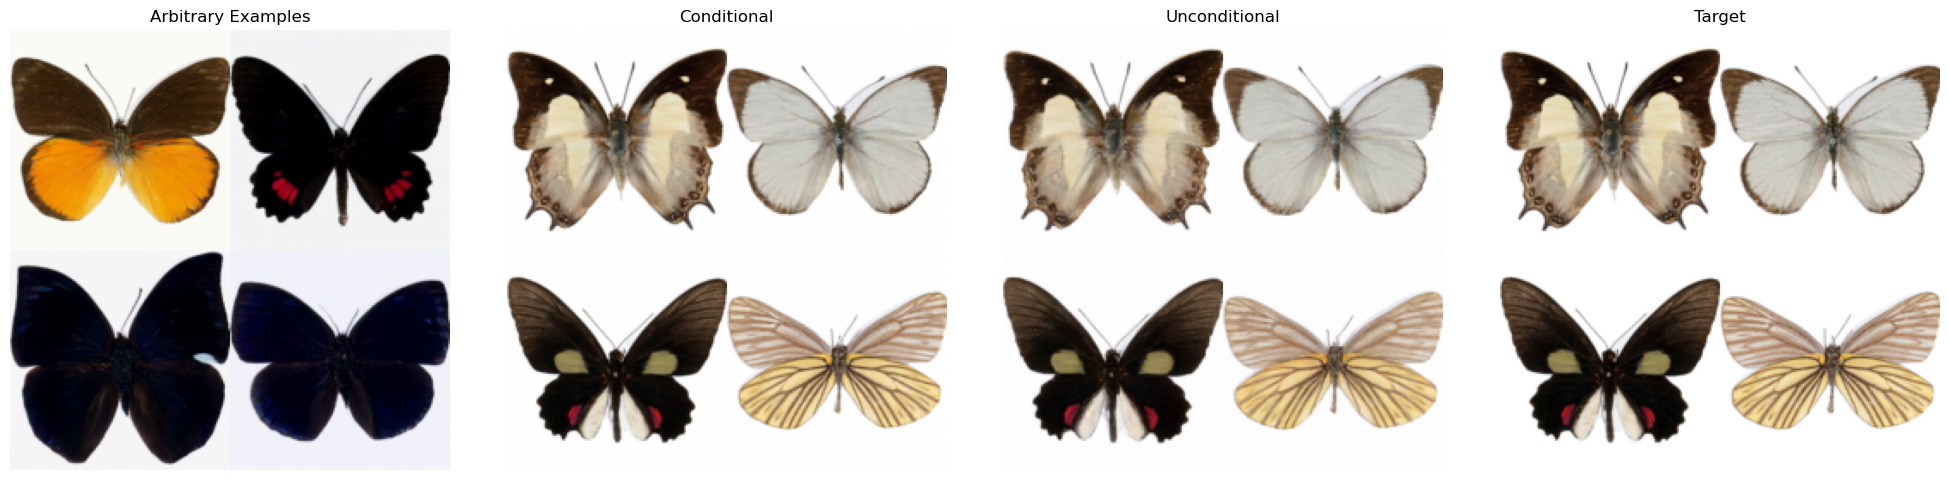

In [118]:
def tensor_to_grid(tensor):
    images = tensor.permute(0, 2, 3, 1).numpy()
    images = ((images / 2 + 0.5) * 255).clip(0, 255).astype(np.uint8)
    pil_images = [Image.fromarray(img) for img in images]
    return make_image_grid(pil_images, rows=2, cols=2)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.tight_layout(pad=1.0)  

axes[0].set_title("Arbitrary Examples")
axes[0].imshow(tensor_to_grid(arbitrary[:4]))
axes[0].axis('off')

axes[1].set_title("Conditional") 
axes[1].imshow(tensor_to_grid(sample_conditional[:4]))
axes[1].axis('off')

axes[2].set_title("Unconditional")
axes[2].imshow(tensor_to_grid(sample_unconditional[:4]))
axes[2].axis('off')

axes[3].set_title("Target")
axes[3].imshow(tensor_to_grid(target[:4]))
axes[3].axis('off')

plt.savefig('comparison_grid.png', dpi=300, bbox_inches='tight')  # Save the figure
plt.show()

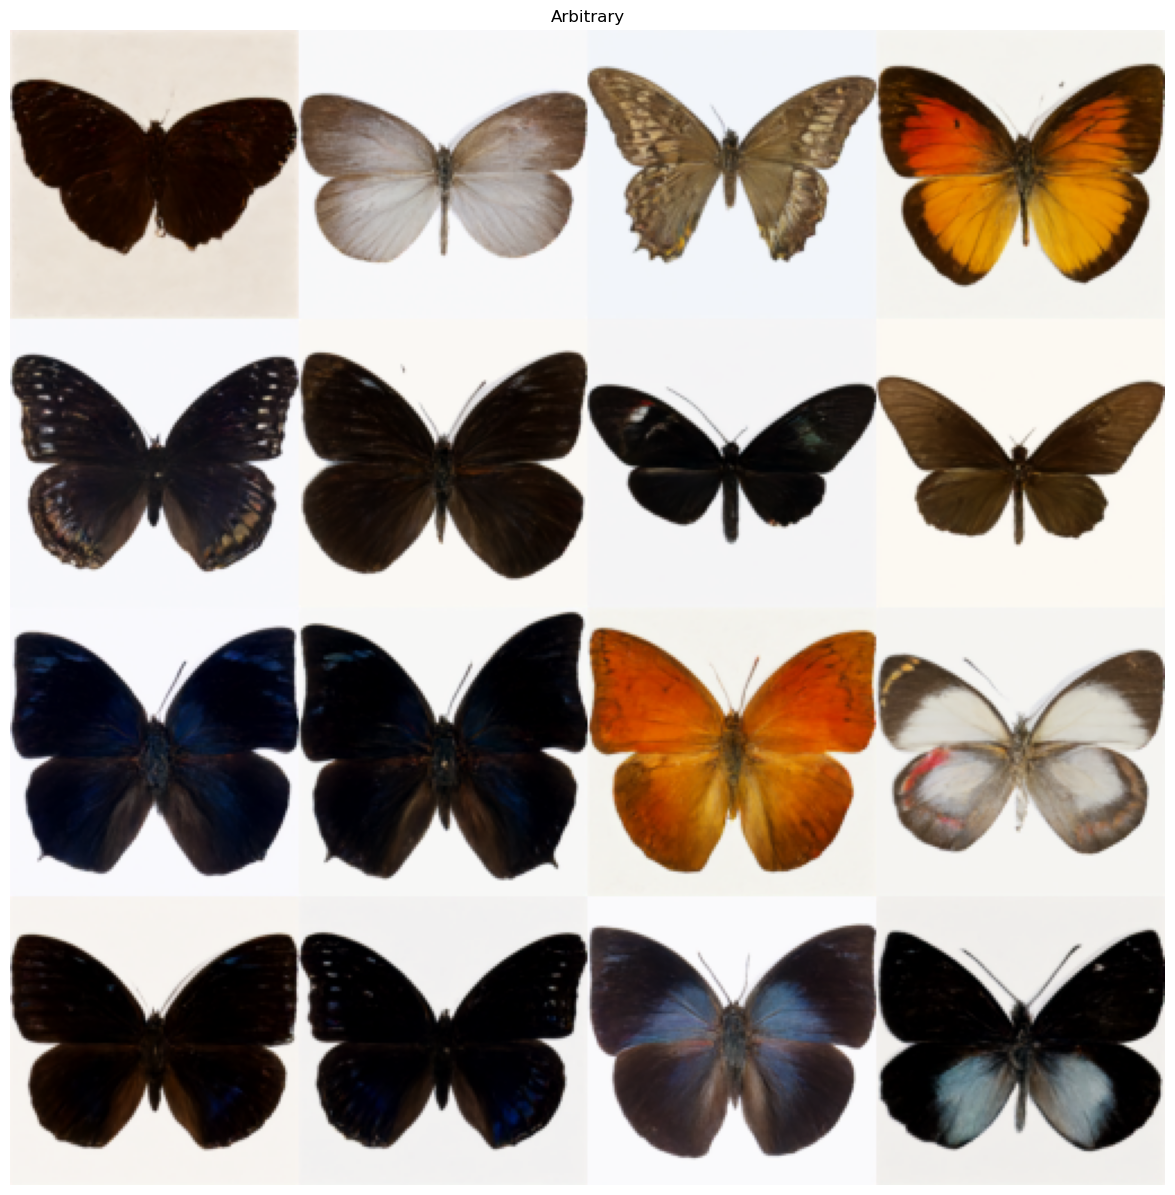

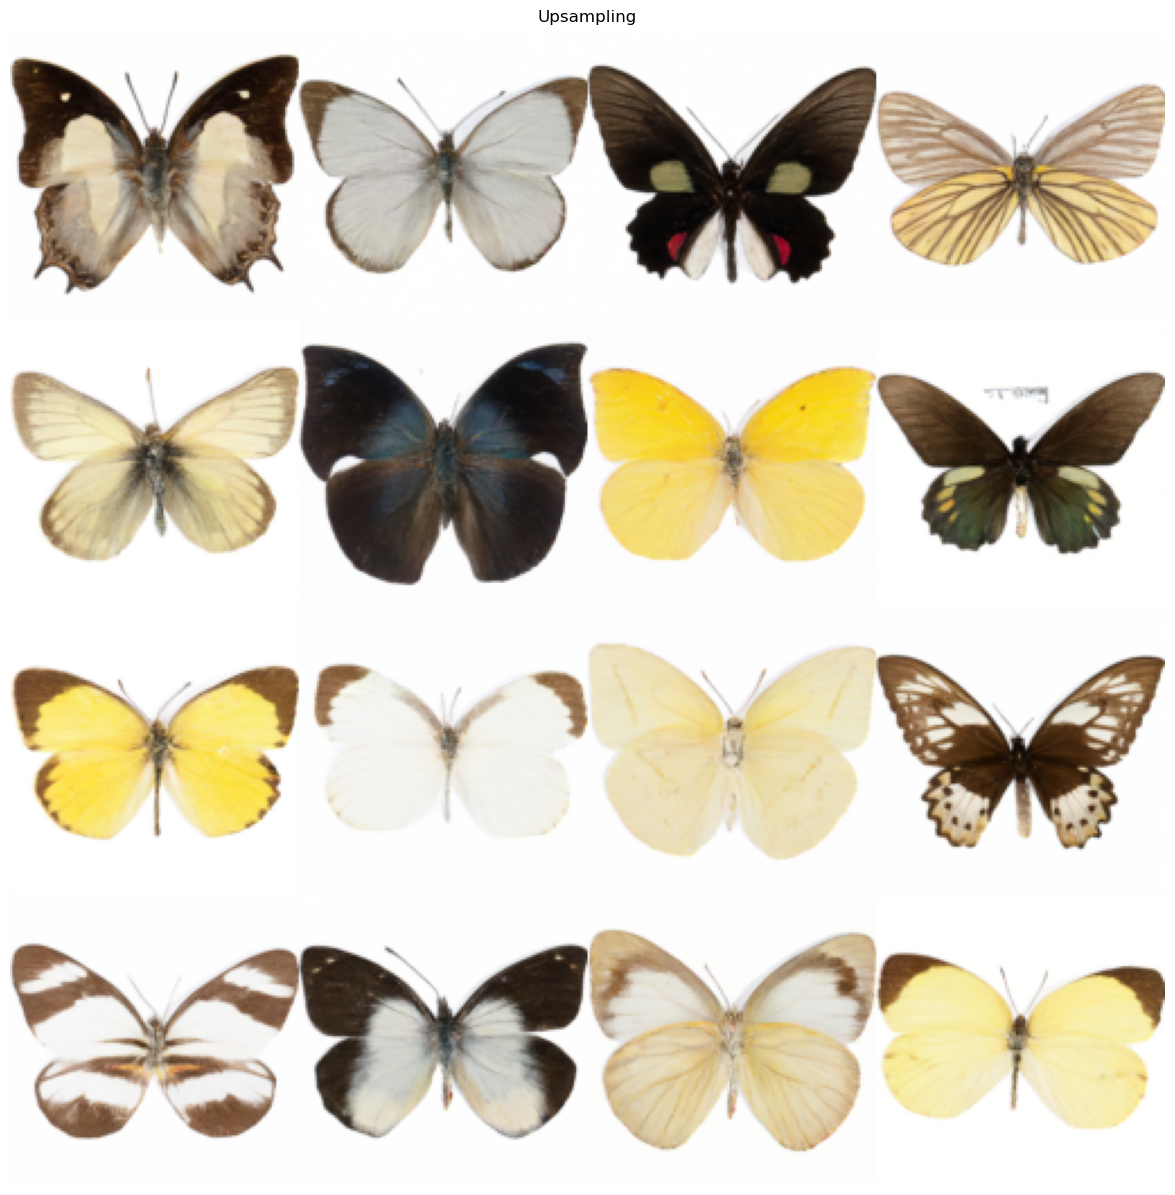

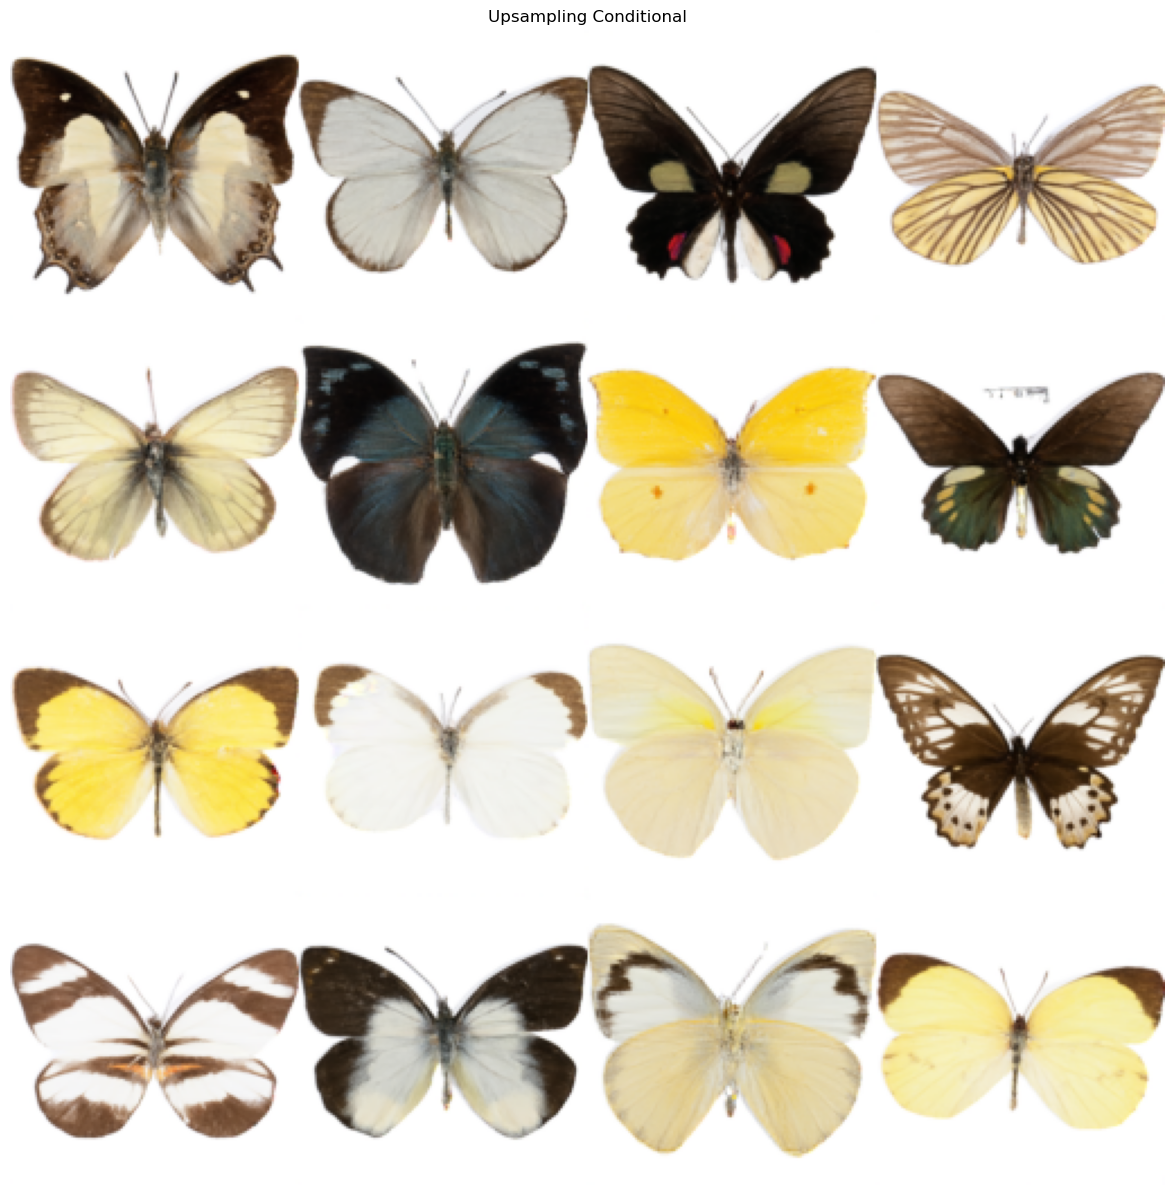

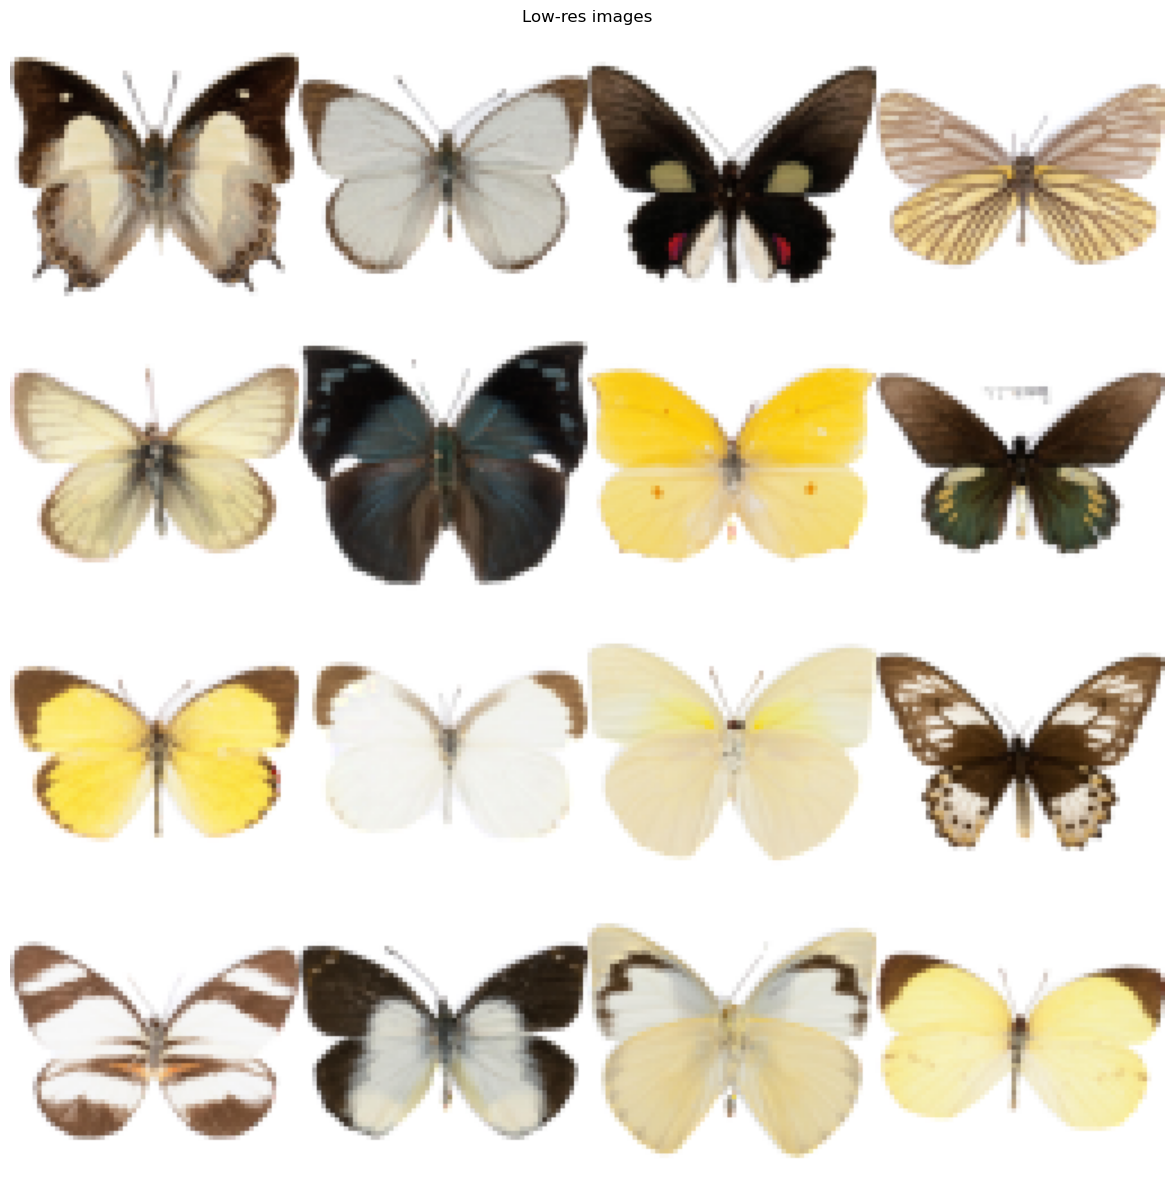

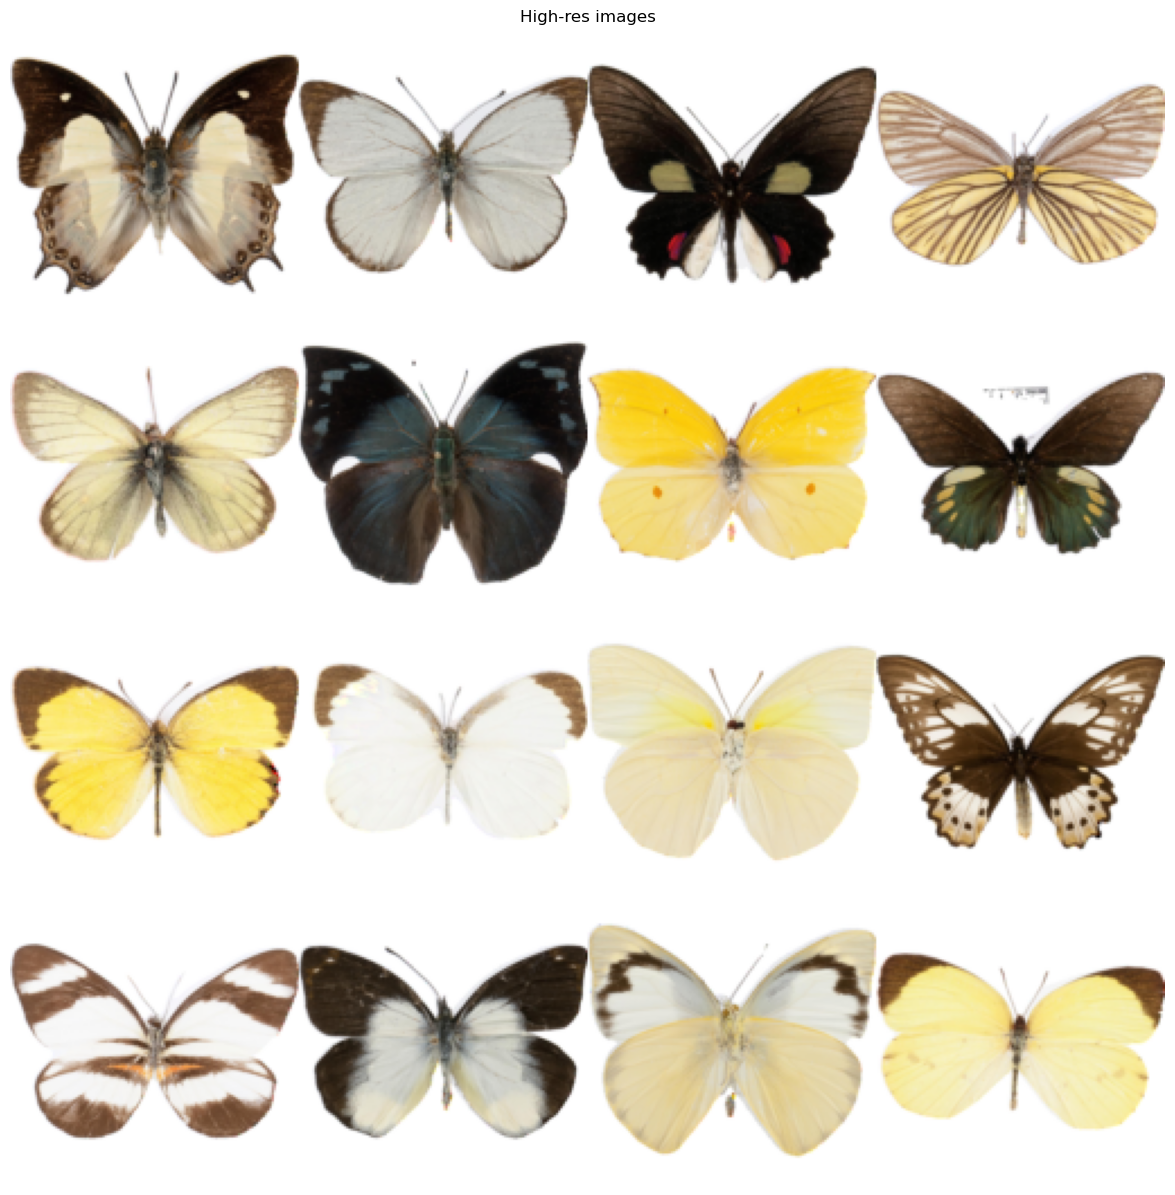

In [112]:


sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
yo = Image.open(sample_images[0]) 
plt.figure(figsize=(15, 15))
plt.title("Arbitrary")
plt.imshow(yo)
plt.axis("off")
plt.show()

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
yo = Image.open(sample_images[1]) 
plt.figure(figsize=(15, 15))
plt.title("Upsampling")
plt.imshow(yo)
plt.axis("off")
plt.show()


sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
yo = Image.open(sample_images[2]) 
plt.figure(figsize=(15, 15))
plt.title("Upsampling Conditional")
plt.imshow(yo)
plt.axis("off")
plt.show()


images_pp = torch.tensor(np.array([(img / 2 + 0.5).clamp(0, 1).numpy() for img in dataset_eval[:16]["low_res_images"]])).permute(0, 2, 3, 1).numpy()
images_pp = (images_pp * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images_pp]
image_grid = make_image_grid(pil_images, rows=4, cols=4)
plt.figure(figsize=(15, 15))
plt.title("Low-res images")
plt.imshow(image_grid)
plt.axis("off")
plt.show()


images_pp = torch.tensor(np.array([(img / 2 + 0.5).clamp(0, 1).numpy() for img in dataset_eval[:16]["high_res_images"]])).permute(0, 2, 3, 1).numpy()
images_pp = (images_pp * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images_pp]
image_grid = make_image_grid(pil_images, rows=4, cols=4)
plt.figure(figsize=(15, 15))
plt.title("High-res images")
plt.imshow(image_grid)
plt.axis("off")
plt.show()


# VALIDATION

In [113]:
import torch
import torch.nn as nn
from torchvision.models import inception_v3
import numpy as np
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

import torch
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_mse(predicted_image: torch.Tensor, target_image: torch.Tensor) -> float:
    mse_loss = nn.MSELoss()
    mse_value = mse_loss(predicted_image, target_image).item()
    return mse_value
def calculate_ssim(predicted_images: torch.Tensor, target_images: torch.Tensor) -> float:
    ssim_values = []
    for pred, target in zip(predicted_images, target_images):
        predicted_image_np = pred.detach().cpu().numpy().transpose(1, 2, 0)
        target_image_np = target.detach().cpu().numpy().transpose(1, 2, 0)

        ssim_value = ssim(
            predicted_image_np,
            target_image_np,
            data_range=2.0,
            multichannel=True,
            channel_axis=-1,
        )
        ssim_values.append(ssim_value)
    
    return sum(ssim_values) / len(ssim_values)

from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_snr(predicted_images: torch.Tensor, target_images: torch.Tensor) -> float:
    psnr_values = []
    for pred, target in zip(predicted_images, target_images):
        predicted_image_np = pred.detach().cpu().numpy().transpose(1, 2, 0)
        target_image_np = target.detach().cpu().numpy().transpose(1, 2, 0)
        
        psnr_value = psnr(target_image_np, predicted_image_np, data_range=2.0)
        psnr_values.append(psnr_value)
    
    return sum(psnr_values) / len(psnr_values)

def evaluate_metrics(high_res_images, generated_images, device='cuda'):
    
    high_res_images = high_res_images.to(device)
    generated_images = generated_images.to(device)
    
    mse = calculate_mse(generated_images, high_res_images)
    ssim_val = calculate_ssim(generated_images, high_res_images)  
    snr = calculate_snr(generated_images, high_res_images)
    
    print(f"MSE: {mse:.4f}")
    print(f"SSIM: {ssim_val:.4f}")
    print(f"SNR: {snr:.4f} dB")

    return mse, ssim_val, snr

print("Unconditional Upsampling")
evaluate_metrics(sample_unconditional, target)
print("Conditional Upsampling")
evaluate_metrics(sample_conditional, target)


Unconditional Upsampling
MSE: 0.0053
SSIM: 0.9014
SNR: 29.9987 dB
Conditional Upsampling
MSE: 0.0015
SSIM: 0.9714
SNR: 35.2552 dB


(0.0015203735092654824, 0.9714448755979538, 35.25516189634628)

In [ ]:
def evaluate_metrics(high_res_images, generated_images, device='cuda'):
    
    high_res_images = high_res_images.to(device)
    generated_images = generated_images.to(device)
    
    mse = calculate_mse(generated_images, high_res_images)
    ssim_val = calculate_ssim(generated_images, high_res_images)
    snr = calculate_snr(generated_images, high_res_images)
    
    return mse, ssim_val, snr

low_res_images = torch.cat([d.unsqueeze(0) for d in dataset_eval[0:0+16]["low_res_images"]], dim=0)
target = torch.cat([d.unsqueeze(0) for d in dataset_eval[0:0+16]["high_res_images"]], dim=0)

mse_list, ssim_list, snr_list = [], [], []
t_values = range(900, 0, -25)

for initial_t in t_values:
    sample_unconditional = evaluate_upsampling(config, 1, pipe, low_res_images, 1000, initial_t, False)
    mse, ssim_val, snr = evaluate_metrics(sample_unconditional, target)
    mse_list.append(mse)
    ssim_list.append(ssim_val)
    snr_list.append(snr)
    print(f"t={initial_t}: MSE={mse:.4f}, SSIM={ssim_val:.4f}, SNR={snr:.4f} dB")





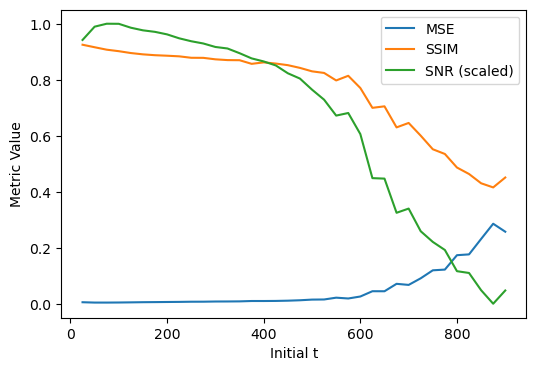

In [104]:
plt.figure(figsize=(6, 4))
# Scale each metric to 0-1 range
#mse_scaled = [(x - min(mse_list)) / (max(mse_list) - min(mse_list)) for x in mse_list]
#ssim_scaled = [(x - min(ssim_list)) / (max(ssim_list) - min(ssim_list)) for x in ssim_list]
snr_scaled = [(x - min(snr_list)) / (max(snr_list) - min(snr_list)) for x in snr_list]

plt.plot(t_values, mse_list, label='MSE')
plt.plot(t_values, ssim_list, label='SSIM') 
plt.plot(t_values, snr_scaled, label='SNR (scaled)')
plt.xlabel('Initial t')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(False)
plt.savefig('metrics_vs_initial_t.png')
plt.show()